In [6]:
import numbers
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import docplex
import docplex.mp.model
import control
import control.matlab

import utility as util

In [7]:
def get_state_space_representation():
    """Get state-space representation of double integrator model."""
    # A, sys.A both have shape (4, 4)
    A = np.diag([1, 1], k=2)
    # B, sys.B both have shape (4, 2)
    B = np.concatenate((np.diag([0,0]), np.diag([1,1]),))
    # C has shape (2, 4)
    C = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=1)
    # D has shape (2, 2)
    D = np.diag([0, 0])
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), 0.5)
    A = np.array(sys.A)
    B = np.array(sys.B)
    return (A, B)

def make_global_params(p_0_x, p_0_y, v_0_x, v_0_y):
    """Get Global LCSS parameters used across all loops"""
    params = util.AttrDict()
    params.M_big = 1000
    params.A, params.B = get_state_space_representation()
    # number of state variables x, number of input variables u
    # nx = 4, nu = 2
    params.nx, params.nu = params.B.shape
    bbox_lon, bbox_lat = 0.6, 0.4
    params.diag = np.sqrt(bbox_lon**2 + bbox_lat**2) / 2.
    # Prediction parameters
    params.T = 8
    params.L = 4 # number of faces of obstacle sets

    # Closed for solution of control without obstacles
    A, B, T, nx, nu = params.A, params.B, params.T, params.nx, params.nu
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)),
            np.linalg.solve(Abar, Bbar),))
    params.Abar = Abar
    params.Bbar = Bbar
    params.Gamma = Gamma

    # x0 : np.array
    #   Initial state
    x0 = np.array([p_0_x, p_0_y, v_0_x, v_0_y])
    params.p_0_x, params.p_0_y, params.v_0_x, params.v_0_y = x0
    A, T = params.A, params.T
    params.theta = np.angle(v_0_x + 1j*v_0_y)
    # params.v_lim = 8.33
    params.v_lim = 2.5
    # States_free_init has shape (nx*(T+1))
    params.States_free_init = np.concatenate([
            np.linalg.matrix_power(A, t) @ x0 for t in range(T+1)])
    return params

def compute_velocity_constraints(param, v_x, v_y):
    """Velocity states have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Street speed limit is 30 km/h == 8.33.. m/s"""
    v_lim = param.v_lim # is m/s
    theta = param.theta
    r = v_lim / 2
    v_1 = r
    v_2 = 0.75 * v_lim
    c1 = v_2*((v_x - r*np.cos(theta))*np.cos(theta) \
            + (v_y - r*np.sin(theta))*np.sin(theta))
    c2 = v_1*((v_y - r*np.sin(theta))*np.cos(theta) \
            - (v_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(v_1 * v_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

def compute_acceleration_constraints(param, u_x, u_y):
    """Accelaration control inputs have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Present performance cars are capable of going from 0 to 60 mph in under 5 seconds.
    Reference:
    https://en.wikipedia.org/wiki/0_to_60_mph"""
    theta = param.theta
    r = -2.5
    a_1 = 7.5
    a_2 = 5.0
    c1 = a_2*((u_x - r*np.cos(theta))*np.cos(theta) \
            + (u_y - r*np.sin(theta))*np.sin(theta))
    c2 = a_1*((u_y - r*np.sin(theta))*np.cos(theta) \
            - (u_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(a_1 * a_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

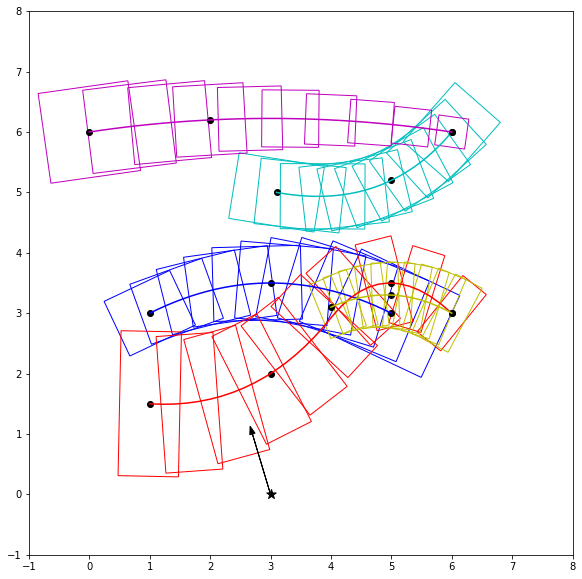

In [8]:
x0 = np.array([3., 0., -0.3, 1.])
p_0_x, p_0_y, v_0_x, v_0_y = x0
params = make_global_params(p_0_x, p_0_y, v_0_x, v_0_y)
T = params.T + 2
params.O = 3
params.K = np.array([1, 2, 2])
fig, ax = plt.subplots(figsize=(10, 10))

points = np.array([
        [1, 3],
        [3, 3.5],
        [5, 3]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-b');
lws = util.kronecker_mul_vectors(np.array([1.2, 1.]), np.linspace(1., 1.5, T))
vertex_set_1 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='blue', fc='none')
    ax.add_patch(patch)

points = np.array([
        [6, 3],
        [5, 3.5],
        [3, 2.],
        [1, 1.5]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-r');
lws = util.kronecker_mul_vectors(np.array([0.5, 1.2]), np.linspace(1., 2., T))
vertex_set_2 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='red', fc='none')
    ax.add_patch(patch)
    
points = np.array([
        [6, 3],
        [5, 3.3],
        [4, 3.1]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-y');
lws = util.kronecker_mul_vectors(np.array([0.5, 1.2]), np.linspace(1., 0.8, T))
vertex_set_3 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)

points = np.array([
        [6, 6],
        [5, 5.2],
        [3.1, 5]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-c');
lws = util.kronecker_mul_vectors(np.array([1.3, 1.]), np.linspace(1., 1.1, T))
vertex_set_4 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)

points = np.array([
        [6, 6],
        [2, 6.2],
        [0, 6]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-m');
lws = util.kronecker_mul_vectors(np.array([0.5, 0.5]), np.linspace(1., 3., T))
vertex_set_5 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)

ax.scatter(p_0_x, p_0_y, marker='*', c='k', s=100)
ax.arrow(p_0_x, p_0_y, v_0_x, v_0_y, color='k', head_width=0.09)

ax.set_aspect('equal')
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8])

O, K = params.O, params.K
A_union = np.empty((T, np.max(K), O,), dtype=object).tolist()
b_union = np.empty((T, np.max(K), O,), dtype=object).tolist()
# vertex_set_x has shape (8, 4, 2)
for t, vertices in enumerate(vertex_set_1):
    A, b = util.vertices_to_halfspace_representation(vertices)
    A_union[t][0][0] = A
    b_union[t][0][0] = b
for t, vertices in enumerate(vertex_set_2):
    A, b = util.vertices_to_halfspace_representation(vertices)
    A_union[t][0][1] = A
    b_union[t][0][1] = b
for t, vertices in enumerate(vertex_set_3):
    A, b = util.vertices_to_halfspace_representation(vertices)
    A_union[t][1][1] = A
    b_union[t][1][1] = b
for t, vertices in enumerate(vertex_set_4):
    A, b = util.vertices_to_halfspace_representation(vertices)
    A_union[t][0][2] = A
    b_union[t][0][2] = b
for t, vertices in enumerate(vertex_set_5):
    A, b = util.vertices_to_halfspace_representation(vertices)
    A_union[t][1][2] = A
    b_union[t][1][2] = b

In [9]:
"""Apply motion planning problem without bounds"""
model = docplex.mp.model.Model(name="proposed_problem")
L, T, K, Gamma, nu, nx = params.L, params.T, \
        params.K, params.Gamma, params.nu, params.nx
u = np.array(model.continuous_var_list(nu*T, lb=-np.inf, ub=np.inf, name='u'), dtype=object)
Delta = np.array(model.binary_var_list(L*np.sum(K)*T, name='delta'), dtype=object).reshape(np.sum(K),T,L)

X = (params.States_free_init + util.obj_matmul(Gamma, u)).reshape(T+1,nx)
_X = X[1:]
U = u.reshape(T,nu)

model.add_constraints(compute_velocity_constraints(params, _X[:,2], _X[:,3]))
model.add_constraints(compute_acceleration_constraints(params, U[:,0], U[:,1]))

_X = X[1:,:2]
T, O, K, diag, M_big = params.T, params.O, params.K, params.diag, params.M_big
for ov_idx in range(O):
    sum_clu = np.sum(K[:ov_idx])
    n_states = K[ov_idx]
    for latent_idx in range(n_states):
        for t in range(T):
            A_obs = A_union[t][latent_idx][ov_idx]
            b_obs = b_union[t][latent_idx][ov_idx]
            indices = sum_clu + latent_idx
            lhs = util.obj_matmul(A_obs, _X[t]) + M_big*(1 - Delta[indices, t])
            rhs = b_obs + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[indices, t]) >= 1)

# start from current vehicle position and minimize the objective
p_0_x, p_0_y = params.p_0_x, params.p_0_y
goal_x, goal_y = 3, 9
start = np.array([p_0_x, p_0_y])
goal = np.array([goal_x, goal_y])
_X = X[1:]
cost = 0.
for t in range(T):
    cost += (_X[t,0] - goal_x)**2 + (_X[t,1] - goal_y)**2
    cost += 0.05*t*(_X[t,2]**2 + _X[t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIQP has 264 rows, 176 columns, and 2112 nonzeros.
Reduced MIQP has 160 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.60 ticks)
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
Reduced MIQP has 264 rows, 176 columns, and 2112 nonzeros.
Reduced MIQP has 160 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.58 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec. (0.04 ticks)
Clique table members: 48.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.01 sec. (5.18 ticks)

        Nodes                                         Cu

In [10]:
"""Apply motion planning problem"""
model = docplex.mp.model.Model(name="proposed_problem")
L, T, K, Gamma, nu, nx = params.L, params.T, \
        params.K, params.Gamma, params.nu, params.nx
u = np.array(model.continuous_var_list(nu*T, lb=-8., ub=8., name='u'), dtype=object)
Delta = np.array(model.binary_var_list(L*np.sum(K)*T, name='delta'), dtype=object).reshape(np.sum(K),T,L)

X = (params.States_free_init + util.obj_matmul(Gamma, u)).reshape(T+1,nx)
_X = X[1:]
U = u.reshape(T,nu)

model.add_constraints(compute_velocity_constraints(params, _X[:,2], _X[:,3]))
model.add_constraints(compute_acceleration_constraints(params, U[:,0], U[:,1]))

_X = X[1:,:2]
T, O, K, diag, M_big = params.T, params.O, params.K, params.diag, params.M_big
for ov_idx in range(O):
    sum_clu = np.sum(K[:ov_idx])
    n_states = K[ov_idx]
    for latent_idx in range(n_states):
        for t in range(T):
            A_obs = A_union[t][latent_idx][ov_idx]
            b_obs = b_union[t][latent_idx][ov_idx]
            indices = sum_clu + latent_idx
            lhs = util.obj_matmul(A_obs, _X[t]) + M_big*(1 - Delta[indices, t])
            rhs = b_obs + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[indices, t]) >= 1)

# start from current vehicle position and minimize the objective
p_0_x, p_0_y = params.p_0_x, params.p_0_y
goal_x, goal_y = 3, 9
start = np.array([p_0_x, p_0_y])
goal = np.array([goal_x, goal_y])
_X = X[1:]
cost = 0.
for t in range(T):
    cost += (_X[t,0] - goal_x)**2 + (_X[t,1] - goal_y)**2
    cost += 0.05*t*(_X[t,2]**2 + _X[t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 39 rows and 31 columns.
MIQP Presolve modified 410 coefficients.
Reduced MIQP has 225 rows, 145 columns, and 1964 nonzeros.
Reduced MIQP has 129 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.77 ticks)
Probing fixed 4 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.69 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 4 rows and 4 columns.
MIQP Presolve modified 128 coefficients.
Aggregator did 2 substitutions.
Reduced MIQP has 219 rows, 139 columns, and 1932 nonzeros.
Reduced MIQP has 123 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.79 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec. (0.24 ticks)
Clique table members: 47

In [5]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta

In [6]:
X_star[1]

array([ 2.74540757,  0.84864143, -0.71836971,  2.39456571])

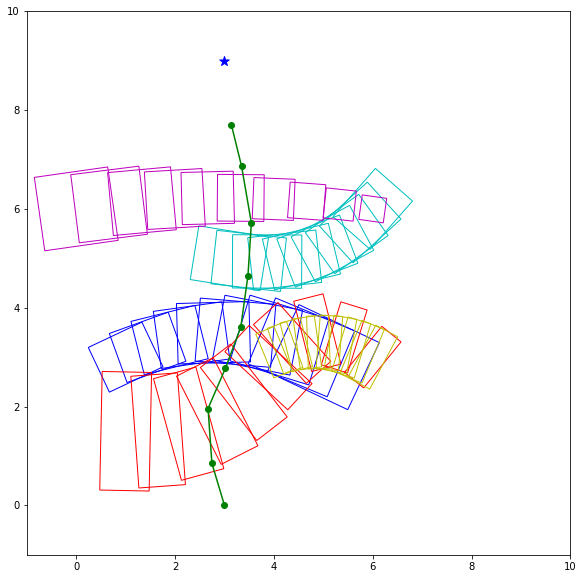

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='r', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)
    
X = X_star[:,:2]
ax.plot(*X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')

ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None

In [8]:
"""Warm-start and apply above same motion planning problem"""
model = docplex.mp.model.Model(name="proposed_problem")
L, T, K, Gamma, nu, nx = params.L, params.T, \
        params.K, params.Gamma, params.nu, params.nx
u = np.array(model.continuous_var_list(nu*T, lb=-8., ub=8., name='u'), dtype=object)
Delta = np.array(model.binary_var_list(L*np.sum(K)*T, name='delta'), dtype=object).reshape(np.sum(K),T,L)

X = (params.States_free_init + util.obj_matmul(Gamma, u)).reshape(T+1,nx)
_X = X[1:]
U = u.reshape(T,nu)

model.add_constraints(compute_velocity_constraints(params, _X[:,2], _X[:,3]))
model.add_constraints(compute_acceleration_constraints(params, U[:,0], U[:,1]))

_X = X[1:,:2]
T, O, K, diag, M_big = params.T, params.O, params.K, params.diag, params.M_big
for ov_idx in range(O):
    sum_clu = np.sum(K[:ov_idx])
    n_states = K[ov_idx]
    for latent_idx in range(n_states):
        for t in range(T):
            A_obs = A_union[t][latent_idx][ov_idx]
            b_obs = b_union[t][latent_idx][ov_idx]
            indices = sum_clu + latent_idx
            lhs = util.obj_matmul(A_obs, _X[t]) + M_big*(1 - Delta[indices, t])
            rhs = b_obs + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[indices, t]) >= 1)

# start from current vehicle position and minimize the objective
p_0_x, p_0_y = params.p_0_x, params.p_0_y
goal_x, goal_y = 3, 9
start = np.array([p_0_x, p_0_y])
goal = np.array([goal_x, goal_y])
_X = X[1:]
cost = 0.
for t in range(T):
    cost += (_X[t,0] - goal_x)**2 + (_X[t,1] - goal_y)**2
    cost += 0.05*t*(_X[t,2]**2 + _X[t,3]**2)
    
model.minimize(cost)
warm_start = model.new_solution()
for i, u in enumerate(U_star):
    warm_start.add_var_value(f"u_{2*i}", u[0])
    warm_start.add_var_value(f"u_{2*i + 1}", u[1])
# for d in Delta_warmstart.ravel():
#     warm_start.add_var_value(d.name, d.solution_value)
warm_start.add_var_value('delta_0', 0)
model.add_mip_start(warm_start)

# for x in model.iter_mip_starts():
#     for y in x[0].iter_var_values():
#         print(y)

# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 226.1291.
Tried aggregator 1 time.
MIQP Presolve eliminated 39 rows and 31 columns.
MIQP Presolve modified 410 coefficients.
Reduced MIQP has 225 rows, 145 columns, and 1964 nonzeros.
Reduced MIQP has 129 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.77 ticks)
Probing fixed 4 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.69 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 4 rows and 4 columns.
MIQP Presolve modified 128 coefficients.
Aggregator did 2 substitutions.
Reduced MIQP has 219 rows, 139 columns, and 1932 nonzeros.
Reduced MIQP has 123 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.79 ticks)
Classifier predict

In [9]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta

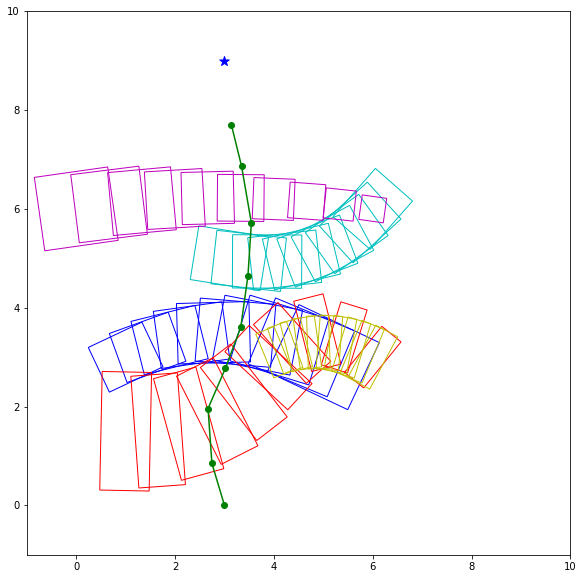

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='r', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)
    
X = X_star[:,:2]
ax.plot(*X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')

ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None

In [11]:
"""Apply motion planning problem to next control step"""
p_0_x, p_0_y, v_0_x, v_0_y = X_star[1]
params = make_global_params(p_0_x, p_0_y, v_0_x, v_0_y)
params.O = 3
params.K = np.array([1, 2, 2])

model = docplex.mp.model.Model(name="proposed_problem")
L, T, K, Gamma, nu, nx = params.L, params.T, \
        params.K, params.Gamma, params.nu, params.nx
u = np.array(model.continuous_var_list(nu*T, lb=-8., ub=8., name='u'), dtype=object)
Delta = np.array(model.binary_var_list(L*np.sum(K)*T, name='delta'), dtype=object).reshape(np.sum(K),T,L)

X = (params.States_free_init + util.obj_matmul(Gamma, u)).reshape(T+1,nx)
_X = X[1:]
U = u.reshape(T,nu)

model.add_constraints(compute_velocity_constraints(params, _X[:,2], _X[:,3]))
model.add_constraints(compute_acceleration_constraints(params, U[:,0], U[:,1]))

_X = X[1:,:2]
T, O, K, diag, M_big = params.T, params.O, params.K, params.diag, params.M_big
for ov_idx in range(O):
    sum_clu = np.sum(K[:ov_idx])
    n_states = K[ov_idx]
    for latent_idx in range(n_states):
        for t in range(T):
            A_obs = A_union[t + 1][latent_idx][ov_idx]
            b_obs = b_union[t + 1][latent_idx][ov_idx]
            indices = sum_clu + latent_idx
            lhs = util.obj_matmul(A_obs, _X[t]) + M_big*(1 - Delta[indices, t])
            rhs = b_obs + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[indices, t]) >= 1)

# start from current vehicle position and minimize the objective
p_0_x, p_0_y = params.p_0_x, params.p_0_y
goal_x, goal_y = 3, 9
start = np.array([p_0_x, p_0_y])
goal = np.array([goal_x, goal_y])
_X = X[1:]
cost = 0.
for t in range(T):
    cost += (_X[t,0] - goal_x)**2 + (_X[t,1] - goal_y)**2
    cost += 0.05*t*(_X[t,2]**2 + _X[t,3]**2)

model.minimize(cost)
warm_start = model.new_solution()
for i, u in enumerate(U_star[1:]):
    warm_start.add_var_value(f"u_{2*i}", u[0])
    warm_start.add_var_value(f"u_{2*i + 1}", u[1])
# warm_start.add_var_value(f"u_{2*(T - 1)}", U_star[-1,0])
# warm_start.add_var_value(f"u_{2*(T - 1) + 1}", U_star[-1,1])
# for d in Delta_warmstart.ravel():
#     warm_start.add_var_value(d.name, d.solution_value)
warm_start.add_var_value('delta_0', 0)
model.add_mip_start(warm_start)

# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 158.7672.
Tried aggregator 1 time.
MIQP Presolve eliminated 31 rows and 25 columns.
MIQP Presolve modified 278 coefficients.
Reduced MIQP has 233 rows, 151 columns, and 2002 nonzeros.
Reduced MIQP has 135 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.74 ticks)
Probing fixed 7 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.78 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 7 rows and 7 columns.
MIQP Presolve modified 191 coefficients.
Aggregator did 3 substitutions.
Reduced MIQP has 223 rows, 141 columns, and 1952 nonzeros.
Reduced MIQP has 125 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.92 ticks)
Classifier predict

In [12]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta

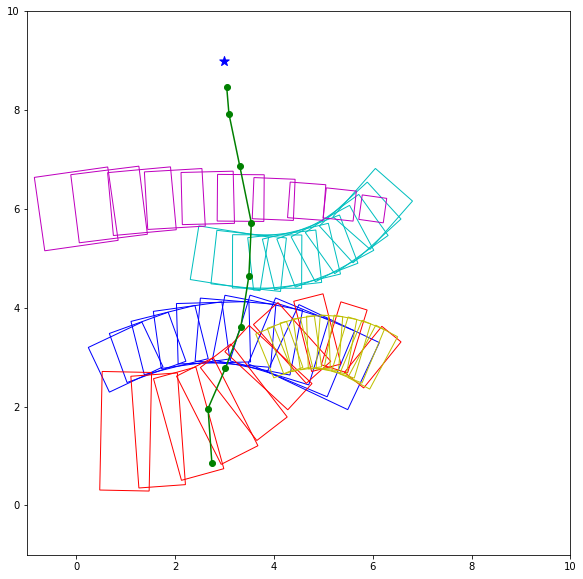

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='r', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)
    
X = X_star[:,:2]
ax.plot(*X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')

ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None

In [22]:
"""Apply motion planning problem to next control step without warm starting"""
x0 = np.array([ 2.74540757,  0.84864143, -0.71836971,  2.39456571 ])
p_0_x, p_0_y, v_0_x, v_0_y = x0
params = make_global_params(p_0_x, p_0_y, v_0_x, v_0_y)
params.O = 3
params.K = np.array([1, 2, 2])

model = docplex.mp.model.Model(name="proposed_problem")
L, T, K, Gamma, nu, nx = params.L, params.T, \
        params.K, params.Gamma, params.nu, params.nx
u = np.array(model.continuous_var_list(nu*T, lb=-8., ub=8., name='u'), dtype=object)
Delta = np.array(model.binary_var_list(L*np.sum(K)*T, name='delta'), dtype=object).reshape(np.sum(K),T,L)

X = (params.States_free_init + util.obj_matmul(Gamma, u)).reshape(T+1,nx)
_X = X[1:]
U = u.reshape(T,nu)

model.add_constraints(compute_velocity_constraints(params, _X[:,2], _X[:,3]))
model.add_constraints(compute_acceleration_constraints(params, U[:,0], U[:,1]))

_X = X[1:,:2]
T, O, K, diag, M_big = params.T, params.O, params.K, params.diag, params.M_big
for ov_idx in range(O):
    sum_clu = np.sum(K[:ov_idx])
    n_states = K[ov_idx]
    for latent_idx in range(n_states):
        for t in range(T):
            A_obs = A_union[t + 1][latent_idx][ov_idx]
            b_obs = b_union[t + 1][latent_idx][ov_idx]
            indices = sum_clu + latent_idx
            lhs = util.obj_matmul(A_obs, _X[t]) + M_big*(1 - Delta[indices, t])
            rhs = b_obs + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[indices, t]) >= 1)

# start from current vehicle position and minimize the objective
p_0_x, p_0_y = params.p_0_x, params.p_0_y
goal_x, goal_y = 3, 9
start = np.array([p_0_x, p_0_y])
goal = np.array([goal_x, goal_y])
_X = X[1:]
cost = 0.
for t in range(T):
    cost += (_X[t,0] - goal_x)**2 + (_X[t,1] - goal_y)**2
    cost += 0.05*t*(_X[t,2]**2 + _X[t,3]**2)

model.minimize(cost)

# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 31 rows and 25 columns.
MIQP Presolve modified 278 coefficients.
Reduced MIQP has 233 rows, 151 columns, and 2002 nonzeros.
Reduced MIQP has 135 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.74 ticks)
Probing fixed 7 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.78 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 7 rows and 7 columns.
MIQP Presolve modified 191 coefficients.
Aggregator did 3 substitutions.
Reduced MIQP has 223 rows, 141 columns, and 1952 nonzeros.
Reduced MIQP has 125 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 128 nonzeros.
Presolve time = 0.00 sec. (0.92 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec. (0.24 ticks)
Clique table members: 41

In [15]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta

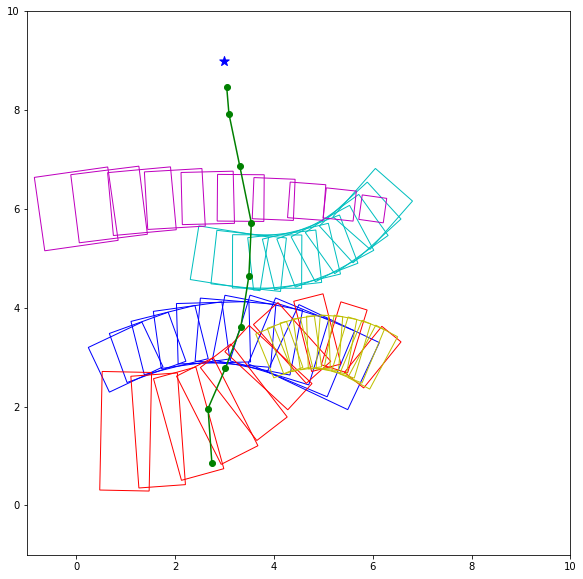

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='r', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)
    
X = X_star[:,:2]
ax.plot(*X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')

ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None